In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from scipy import interpolate
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import datetime as datetime
from geopack import geopack

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import xarray as xr

import torch
import torch.nn as nn

Load IGRF coefficients ...


In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 40 * 140)

    def forward(self, x):
        batch_size = x.size(0)
        # Use the same device as the model for hidden states
        device = next(self.parameters()).device  # Ensure hidden states are on the same device as the model
        
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size, device=device)  # Initial hidden state
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size, device=device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = out.view(-1, 40, 140)
        return out

    def reset_states(self):
        # Reset the internal states of the LSTM layer
        self.lstm.reset_parameters()

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
lookback = 30

def load_model(model_path,lookback=30):

    model = LSTM(lookback, 128, 2)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)

    return model

#NH
NH_sxx_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_sxx_NH_id1.pt") 
NH_syy_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_syy_NH_id1.pt")
NH_fac_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_fac_NH_id2.pt")
NH_pot_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_pot_NH_id2.pt")

In [4]:
def make_predictions(model, feat, hemi, By, Bz, id):
    
    flow_speed = 450
    proton_density = 5
    tilt = 0

    BY_arr = np.repeat(By, lookback+1)
    BZ_arr = np.repeat(Bz, lookback+1)
    flow_speed_arr = np.repeat(flow_speed, lookback+1)
    proton_density_arr = np.repeat(proton_density, lookback+1)
    tilt_angle_arr = np.repeat(tilt, lookback+1)


    df = pd.DataFrame({'BY': BY_arr, 'BZ': BZ_arr, 'flow_speed': flow_speed_arr,'proton_density': proton_density_arr, 'tilt_angle': tilt_angle_arr})


    with open(f'/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_scaler_{feat}_{hemi}_id{id}.pkl', 'rb') as f:
        scaler = pickle.load(f)

    #col_names = df.columns
    norm_arr = scaler.transform(df)
    #df_proc = pd.DataFrame(norm_arr, columns=col_names)
    #df_proc = df_proc.to_numpy()

    def create_sequences(arr, lb):
        X = []
        for i in range(len(arr) - lb):
            X.append(arr[i:i+lb].T)

        X = np.array(X)

        return X

    proc_seq = create_sequences(norm_arr, lookback)
    proc_seq = torch.tensor(proc_seq, dtype=torch.float32).to(device)

    predictions = []
    with torch.no_grad():
        for i in range(len(proc_seq)):
            pred = model(proc_seq[i].unsqueeze(0))
            predictions.append(pred)

    predictions = torch.cat(predictions)
    predictions = predictions.to('cpu').numpy()

    predictions = predictions.reshape(40,140)
    #predictions = np.flipud(predictions)

    return predictions

make_predictions(NH_fac_model,'fac','NH', -5, 5, 2) #0,0


/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


array([[ 9.7292050e-06, -5.0263020e-06,  7.5579158e-07, ...,
         3.8376347e-06, -7.7109235e-09, -6.9203647e-06],
       [-1.0091458e-05, -3.8744211e-06,  4.8234979e-06, ...,
         4.4408271e-06, -8.1209134e-07, -5.2599444e-07],
       [-1.9286042e-06,  3.4293321e-06,  6.1533760e-06, ...,
         1.6481009e-06,  7.7711702e-06,  3.2767707e-07],
       ...,
       [ 6.2919758e-02,  6.1496563e-02,  6.0130842e-02, ...,
         6.7778043e-02,  6.6637248e-02,  6.5606825e-02],
       [ 6.5856159e-02,  6.5268993e-02,  6.4165093e-02, ...,
         7.1575418e-02,  7.0035227e-02,  6.9551580e-02],
       [ 7.1083128e-02,  7.0191190e-02,  6.9533013e-02, ...,
         7.1244352e-02,  7.1684420e-02,  7.1505845e-02]], dtype=float32)

In [18]:
feat = 'pot'
id = 2
model = NH_pot_model

neg_y_pos_z_nh = make_predictions(model,feat,'NH', -5, 5, id) #0,0
neu_y_pos_z_nh = make_predictions(model,feat,'NH', 0, 5, id) #0,1
pos_y_pos_z_nh = make_predictions(model,feat,'NH', 5, 5, id) #0,2

neg_y_neu_z_nh = make_predictions(model,feat,'NH', -5, 0, id) #1,0
neu_y_neu_z_nh = make_predictions(model,feat,'NH', 0, 0, id) #1,1
pos_y_neu_z_nh = make_predictions(model,feat,'NH', 5, 0, id) #1,2

neg_y_neg_z_nh = make_predictions(model,feat,'NH', -5, -5, id) #2,0
neu_y_neg_z_nh = make_predictions(model,feat,'NH', 0, -5, id) #2,1
pos_y_neg_z_nh = make_predictions(model,feat,'NH', 5, -5, id) #2,2

/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/l

In [19]:
mlat = np.linspace(50, 90, 40)
mlt = np.linspace(0, 360, 140)

def calculate_distance(lat1, lon1, lat2, lon2):
    radius = 6371.008 * 1000 #km to m

    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    delta_x = dlat * radius #111.32 km per degree
    delta_y = dlon * radius * np.cos(np.radians(lat1)) 

    #area = delta_x * delta_y
    #avg_lat = np.radians(lat1 + lat2) / 2
    #area = radius**2 *  dlat * dlon * np.cos(avg_lat)
    area = radius**2 * (np.sin(np.radians(lat2)) - np.sin(np.radians(lat1))) * (np.radians(lon2) - np.radians(lon1))
    
    return delta_x, delta_y, area

def calculate_delta(mlat, mlt):
    #loop through lat and lon and calculate distance between each point
    delta_x = np.zeros((len(mlat) - 1, len(mlt) - 1))
    delta_y = np.zeros((len(mlat) - 1, len(mlt) - 1))
    areas = np.zeros((len(mlat) - 1, len(mlt) - 1))
    for i in range(len(mlat) - 1):
        for j in range(len(mlt) - 1):
            lat1, lat2 = mlat[i], mlat[i + 1]
            lon1, lon2 = mlt[j], mlt[j + 1]

            dx, dy, area = calculate_distance(lat1, lon1, lat2, lon2)
            delta_x[i, j] = dx
            delta_y[i, j] = dy
            areas[i, j] = area

    x = np.arange(areas.shape[1])
    y = np.arange(areas.shape[0])
    f = interpolate.interp2d(x, y, areas, kind='linear')
    xnew = np.arange(0, areas.shape[1], areas.shape[1]/(areas.shape[1]+1))
    ynew = np.arange(0, areas.shape[0], areas.shape[0]/(areas.shape[0]+1))
    areas = f(xnew, ynew)

    return areas

areas = calculate_delta(mlat, mlt)

/tmp/ipykernel_6741/3253781978.py:36: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(x, y, areas, kind='linear')
/tmp/ipykernel_6741/3253781978.py:39: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` 

In [20]:
neg_y_pos_z_int_nh = np.sum(np.abs(neg_y_pos_z_nh) * areas) / 1e12
neu_y_pos_z_int_nh = np.sum(np.abs(neu_y_pos_z_nh) * areas) / 1e12
pos_y_pos_z_int_nh = np.sum(np.abs(pos_y_pos_z_nh) * areas) / 1e12
neg_y_neu_z_int_nh = np.sum(np.abs(neg_y_neu_z_nh) * areas) / 1e12
neu_y_neu_z_int_nh = np.sum(np.abs(neu_y_neu_z_nh) * areas) / 1e12
pos_y_neu_z_int_nh = np.sum(np.abs(pos_y_neu_z_nh) * areas) / 1e12
neg_y_neg_z_int_nh = np.sum(np.abs(neg_y_neg_z_nh) * areas) / 1e12
neu_y_neg_z_int_nh = np.sum(np.abs(neu_y_neg_z_nh) * areas) / 1e12
pos_y_neg_z_int_nh = np.sum(np.abs(pos_y_neg_z_nh) * areas) / 1e12

In [8]:
#int_dict_nh = {'neg_y_pos_z': neg_y_pos_z_int_nh, 'neu_y_pos_z': neu_y_pos_z_int_nh, 'pos_y_pos_z': pos_y_pos_z_int_nh, 'neg_y_neu_z': neg_y_neu_z_int_nh, 'neu_y_neu_z': neu_y_neu_z_int_nh, 'pos_y_neu_z': pos_y_neu_z_int_nh, 'neg_y_neg_z': neg_y_neg_z_int_nh, 'neu_y_neg_z': neu_y_neg_z_int_nh, 'pos_y_neg_z': pos_y_neg_z_int_nh}
#int_dict_sh = {'neg_y_pos_z': neg_y_pos_z_int_sh, 'neu_y_pos_z': neu_y_pos_z_int_sh, 'pos_y_pos_z': pos_y_pos_z_int_sh, 'neg_y_neu_z': neg_y_neu_z_int_sh, 'neu_y_neu_z': neu_y_neu_z_int_sh, 'pos_y_neu_z': pos_y_neu_z_int_sh, 'neg_y_neg_z': neg_y_neg_z_int_sh, 'neu_y_neg_z': neu_y_neg_z_int_sh, 'pos_y_neg_z': pos_y_neg_z_int_sh}

<>:76: SyntaxWarning: invalid escape sequence '\p'
<>:91: SyntaxWarning: invalid escape sequence '\i'
<>:92: SyntaxWarning: invalid escape sequence '\i'
<>:93: SyntaxWarning: invalid escape sequence '\i'
<>:94: SyntaxWarning: invalid escape sequence '\i'
<>:95: SyntaxWarning: invalid escape sequence '\i'
<>:96: SyntaxWarning: invalid escape sequence '\i'
<>:97: SyntaxWarning: invalid escape sequence '\i'
<>:98: SyntaxWarning: invalid escape sequence '\i'
<>:99: SyntaxWarning: invalid escape sequence '\i'
<>:76: SyntaxWarning: invalid escape sequence '\p'
<>:91: SyntaxWarning: invalid escape sequence '\i'
<>:92: SyntaxWarning: invalid escape sequence '\i'
<>:93: SyntaxWarning: invalid escape sequence '\i'
<>:94: SyntaxWarning: invalid escape sequence '\i'
<>:95: SyntaxWarning: invalid escape sequence '\i'
<>:96: SyntaxWarning: invalid escape sequence '\i'
<>:97: SyntaxWarning: invalid escape sequence '\i'
<>:98: SyntaxWarning: invalid escape sequence '\i'
<>:99: SyntaxWarning: invalid e

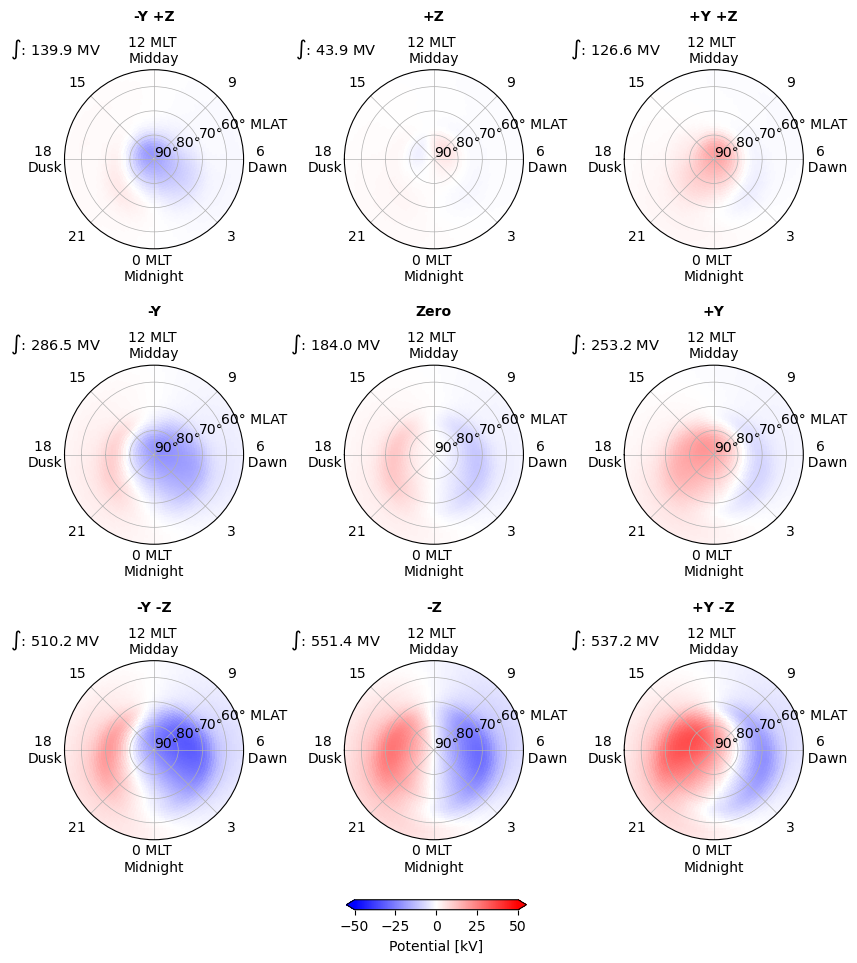

In [25]:
fig, ax = plt.subplots(3,3,figsize=(10, 10), subplot_kw={'projection': 'polar'})

# Define radial and angular coordinates
theta = np.linspace(0, 360, 140) - 90
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(50, 90, 40)

plt.subplots_adjust(wspace=0.3, hspace=0.65)
vmin = -50
vmax = 50

# Plot the data
plots = [
    ax[0,0].pcolormesh(theta_rad, r, neg_y_pos_z_nh, cmap='bwr', vmin=vmin, vmax=vmax),
    ax[0,1].pcolormesh(theta_rad, r, neu_y_pos_z_nh, cmap='bwr', vmin=vmin, vmax=vmax),
    ax[0,2].pcolormesh(theta_rad, r, pos_y_pos_z_nh, cmap='bwr', vmin=vmin, vmax=vmax),
    ax[1,0].pcolormesh(theta_rad, r, neg_y_neu_z_nh, cmap='bwr', vmin=vmin, vmax=vmax),
    ax[1,1].pcolormesh(theta_rad, r, neu_y_neu_z_nh, cmap='bwr', vmin=vmin, vmax=vmax),
    ax[1,2].pcolormesh(theta_rad, r, pos_y_neu_z_nh, cmap='bwr', vmin=vmin, vmax=vmax),
    ax[2,0].pcolormesh(theta_rad, r, neg_y_neg_z_nh, cmap='bwr', vmin=vmin, vmax=vmax),
    ax[2,1].pcolormesh(theta_rad, r, neu_y_neg_z_nh, cmap='bwr', vmin=vmin, vmax=vmax),
    ax[2,2].pcolormesh(theta_rad, r, pos_y_neg_z_nh, cmap='bwr', vmin=vmin, vmax=vmax)
]

#subplot titles
ax[0,0].set_title('-Y +Z', fontsize=10, pad=10.5, fontweight='bold')
ax[0,1].set_title('+Z', fontsize=10, pad=10.5, fontweight='bold')
ax[0,2].set_title('+Y +Z', fontsize=10, pad=10.5, fontweight='bold')
ax[1,0].set_title('-Y', fontsize=10, pad=10.5, fontweight='bold')
ax[1,1].set_title('Zero', fontsize=10, pad=10.5, fontweight='bold')
ax[1,2].set_title('+Y', fontsize=10, pad=10.5, fontweight='bold')
ax[2,0].set_title('-Y -Z', fontsize=10, pad=10.5, fontweight='bold')
ax[2,1].set_title('-Z', fontsize=10, pad=10.5, fontweight='bold')
ax[2,2].set_title('+Y -Z', fontsize=10, pad=10.5, fontweight='bold')



'''nhsh_ratio = r'$\frac{in}{out}$'
ax[0,0].annotate(f'{nhsh_ratio}: {neg_y_pos_z_ratio:.1f}', xy=(1.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[0,1].annotate(f'{nhsh_ratio}: {neu_y_pos_z_ratio:.1f}', xy=(1.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[0,2].annotate(f'{nhsh_ratio}: {pos_y_pos_z_ratio:.1f}', xy=(1.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[1,0].annotate(f'{nhsh_ratio}: {neg_y_neu_z_ratio:.1f}', xy=(1.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[1,1].annotate(f'{nhsh_ratio}: {neu_y_neu_z_ratio:.1f}', xy=(1.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[1,2].annotate(f'{nhsh_ratio}: {pos_y_neu_z_ratio:.1f}', xy=(1.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[2,0].annotate(f'{nhsh_ratio}: {neg_y_neg_z_ratio:.1f}', xy=(1.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[2,1].annotate(f'{nhsh_ratio}: {neu_y_neg_z_ratio:.1f}', xy=(1.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[2,2].annotate(f'{nhsh_ratio}: {pos_y_neg_z_ratio:.1f}', xy=(1.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)'''

'''#day night ratio
ax[0,0].annotate(f'D/N: {neg_y_pos_z_daynight:.1f}', xy=(1.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[0,1].annotate(f'D/N: {neu_y_pos_z_daynight:.1f}', xy=(1.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[0,2].annotate(f'D/N: {pos_y_pos_z_daynight:.1f}', xy=(1.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[1,0].annotate(f'D/N: {neg_y_neu_z_daynight:.1f}', xy=(1.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[1,1].annotate(f'D/N: {neu_y_neu_z_daynight:.1f}', xy=(1.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[1,2].annotate(f'D/N: {pos_y_neu_z_daynight:.1f}', xy=(1.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[2,0].annotate(f'D/N: {neg_y_neg_z_daynight:.1f}', xy=(1.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[2,1].annotate(f'D/N: {neu_y_neg_z_daynight:.1f}', xy=(1.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[2,2].annotate(f'D/N: {pos_y_neg_z_daynight:.1f}', xy=(1.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)'''


for i in range(3):
    for j in range(3):
        ax[i, j].set_ylim([0, 37])
        ax[i, j].set_yticks([0, 10, 20, 30])
        ax[i, j].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
        ax[i, j].set_xlim([-np.pi, np.pi])
        ax[i, j].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
        ax[i, j].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
        ax[i, j].grid(True, linestyle='-', linewidth=0.5, zorder=6)

# Define the position for the colorbar manually
cbar_ax = fig.add_axes([0.425, 0.04, 0.18, 0.01])  # [left, bottom, width, height]

# Add the colorbar
if feat == 'fac':
    fig.colorbar(plots[-1], cax=cbar_ax, label='FAC / J$_\parallel$ [µA/m$^2$]', 
                orientation='horizontal', ticks=[-1, -0.5, 0, 0.5, 1], 
                extend='both')
    units = 'MA'
elif feat == 'pot':
    fig.colorbar(plots[-1], cax=cbar_ax, label='Potential [kV]', 
                orientation='horizontal', ticks=[-50, -25, 0, 25, 50], 
                extend='both')
    units = 'MV'
else:
    fig.colorbar(plots[-1], cax=cbar_ax, label='Conductivity [S/m]', 
                orientation='horizontal', ticks=[0, 5, 10, 15, 20], 
                extend='both')
    units = 'S/m'    
    
ax[0,0].annotate(f'$\int$: {neg_y_pos_z_int_nh:.1f} {units}', xy=(-0.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[0,1].annotate(f'$\int$: {neu_y_pos_z_int_nh:.1f} {units}', xy=(-0.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[0,2].annotate(f'$\int$: {pos_y_pos_z_int_nh:.1f} {units}', xy=(-0.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[1,0].annotate(f'$\int$: {neg_y_neu_z_int_nh:.1f} {units}', xy=(-0.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[1,1].annotate(f'$\int$: {neu_y_neu_z_int_nh:.1f} {units}', xy=(-0.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[1,2].annotate(f'$\int$: {pos_y_neu_z_int_nh:.1f} {units}', xy=(-0.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[2,0].annotate(f'$\int$: {neg_y_neg_z_int_nh:.1f} {units}', xy=(-0.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[2,1].annotate(f'$\int$: {neu_y_neg_z_int_nh:.1f} {units}', xy=(-0.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)
ax[2,2].annotate(f'$\int$: {pos_y_neg_z_int_nh:.1f} {units}', xy=(-0.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10.5)


#control width between plots
#plt.tight_layout()
#plt.savefig('smrai3_lstm_pot_NH.png', dpi=500, bbox_inches='tight')